In [24]:
import pandas as pd
url = 'https://github.com/mattharrison/datasets/raw/master/data/siena2018-pres.csv'
df = pd.read_csv(url, index_col=0, dtype_backend='pyarrow')

In [25]:
def tweak_siena_pres(df):
    def int64_to_uint8(df_):
        cols = df_.select_dtypes('int64')
        return (df_
                .astype({col:'uint8[pyarrow]' for col in cols}))
    return (df
            .rename(columns={'Seq.': 'Seq'}) # 1
            .rename(columns={k:v.replace(' ', '_') for k,v in
                             {'Bg': 'Background',
                              'PL': 'Party leadership', 'CAb': 'Communication ability',
                              'RC': 'Relations with Congress', 'CAp': 'Court appointments',
                              'HE': 'Handling of economy', 'L': 'Luck',
                              'AC': 'Ability to compromise', 'WR': 'Willing to take risks',
                              'EAp': 'Executive appointments', 'OA': 'Overall ability',
                              'Im': 'Imagination', 'DA': 'Domestic accomplishments',
                              'Int': 'Integrity', 'EAb': 'Executive ability',
                              'FPA': 'Foreign policy accomplishments',
                              'LA': 'Leadership ability',
                              'IQ': 'Intelligence', 'AM': 'Avoid crucial mistakes',
                              'EV': "Experts' view", 'O': 'Overall'}.items()})
                              .astype({'Party':'category'})  # 2
                              .pipe(int64_to_uint8)  # 3
                              .assign(Average_rank=lambda df_:(df_.select_dtypes('uint8')
                                                               .sum(axis=1).rank(method='dense').astype('uint8[pyarrow]')),
                                                               Quartile=lambda df_:pd.qcut(df_.Average_rank, 4,
                                                                                           labels='1st 2nd 3rd 4th'.split())
                                    )
    )


In [26]:
pres = tweak_siena_pres(df)

In [27]:
scores = (pres
          .loc[:,'Background':'Average_rank']
          )
scores

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
1,7,7,1,10,1,6,2,2,1,11,...,1,1,1,1,2,2,1,2,1,1
2,3,13,4,4,24,14,31,21,21,13,...,17,4,13,15,19,13,16,10,14,13
3,2,2,14,1,8,5,14,6,6,4,...,5,7,20,4,6,9,7,5,5,5
4,4,6,7,3,16,15,6,13,17,10,...,10,6,14,7,11,19,11,8,7,7
5,9,14,11,18,6,16,7,10,12,15,...,8,11,9,9,10,5,6,9,8,8
6,1,9,6,5,29,19,24,22,23,12,...,29,15,17,18,21,15,14,18,18,18
7,37,15,29,28,4,4,38,11,9,18,...,16,30,25,25,17,23,20,19,19,19
8,23,22,27,25,34,28,20,28,27,25,...,23,25,31,26,29,27,24,28,25,25
9,22,38,28,37,44,32,41,38,29,31,...,37,42,41,40,42,44,37,39,39,38
10,34,33,35,34,22,26,37,36,37,34,...,40,38,34,36,36,26,32,36,37,37


In [28]:

s1 = scores.iloc[:3, :4]
s1

,Background,Imagination,Integrity,Intelligence
1,7,7,1,10
2,3,13,4,4
3,2,2,14,1


In [29]:
s2 = scores.iloc[1:6, :5]
s2

,Background,Imagination,Integrity,Intelligence,Luck
2,3,13,4,4,24
3,2,2,14,1,8
4,4,6,7,3,16
5,9,14,11,18,6
6,1,9,6,5,29


In [30]:
s1+s2

,Background,Imagination,Integrity,Intelligence,Luck
1,<NA>,<NA>,<NA>,<NA>,NaN
2,6,26,8,8,NaN
3,4,4,28,2,NaN
4,<NA>,<NA>,<NA>,<NA>,NaN
5,<NA>,<NA>,<NA>,<NA>,NaN
6,<NA>,<NA>,<NA>,<NA>,NaN


In [31]:
(scores.iloc[:3, :4] + 
 pd.concat([scores.iloc[1:6, :5]]*2))

,Background,Imagination,Integrity,Intelligence,Luck
1,<NA>,<NA>,<NA>,<NA>,NaN
2,6,26,8,8,NaN
2,6,26,8,8,NaN
3,4,4,28,2,NaN
3,4,4,28,2,NaN
4,<NA>,<NA>,<NA>,<NA>,NaN
4,<NA>,<NA>,<NA>,<NA>,NaN
5,<NA>,<NA>,<NA>,<NA>,NaN
5,<NA>,<NA>,<NA>,<NA>,NaN
6,<NA>,<NA>,<NA>,<NA>,NaN


In [32]:
pd.concat([scores.iloc[:3, :4]] + [scores.iloc[1:6, :5]]).index.duplicated().any() # Concat requires lists

np.True_

In [33]:
(scores.Imagination.sub(scores.Imagination.min())
 .div(scores.Imagination.max() - scores.Imagination.min()))

1     0.142857
2     0.285714
3      0.02381
4     0.119048
5     0.309524
6     0.190476
7     0.333333
8          0.5
9     0.880952
10    0.761905
11    0.214286
12    0.595238
13    0.857143
14    0.904762
15         1.0
16         0.0
17     0.97619
18    0.547619
19    0.690476
20    0.571429
21    0.714286
22     0.52381
23    0.785714
24    0.452381
25    0.071429
26    0.642857
27    0.166667
28    0.952381
29    0.833333
30    0.809524
31    0.047619
32    0.357143
33    0.404762
34    0.095238
35    0.238095
36     0.47619
37    0.738095
38    0.428571
39    0.380952
40    0.619048
41    0.261905
42    0.666667
43    0.238095
44    0.928571
Name: Imagination, dtype: double[pyarrow]

In [34]:
imag = scores.Imagination
((imag - imag.min()) / 
 (imag.max() - imag.min()))

1     0.142857
2     0.285714
3      0.02381
4     0.119048
5     0.309524
6     0.190476
7     0.333333
8          0.5
9     0.880952
10    0.761905
11    0.214286
12    0.595238
13    0.857143
14    0.904762
15         1.0
16         0.0
17     0.97619
18    0.547619
19    0.690476
20    0.571429
21    0.714286
22     0.52381
23    0.785714
24    0.452381
25    0.071429
26    0.642857
27    0.166667
28    0.952381
29    0.833333
30    0.809524
31    0.047619
32    0.357143
33    0.404762
34    0.095238
35    0.238095
36     0.47619
37    0.738095
38    0.428571
39    0.380952
40    0.619048
41    0.261905
42    0.666667
43    0.238095
44    0.928571
Name: Imagination, dtype: double[pyarrow]

In [35]:
(scores.Imagination.sub(scores.Imagination.min())
 .div(scores.Imagination.max() - scores.Imagination.min()).describe())

count        44.0
mean     0.494048
std      0.298095
min           0.0
25%      0.238095
50%      0.488095
75%      0.744048
max           1.0
Name: Imagination, dtype: double[pyarrow]

In [36]:
nums = scores.select_dtypes('number')

In [37]:
(nums.sub(nums.min())).div(nums.max().sub(nums.min()))

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
1,0.142857,0.142857,0.0,0.209302,0.0,0.125,0.02381,0.02381,0.0,0.232558,...,0.0,0.0,0.0,0.0,0.023256,0.023256,0.0,0.023256,0.0,0.0
2,0.047619,0.285714,0.069767,0.069767,0.534884,0.325,0.714286,0.47619,0.465116,0.27907,...,0.380952,0.069767,0.27907,0.325581,0.418605,0.27907,0.348837,0.209302,0.302326,0.27907
3,0.02381,0.02381,0.302326,0.0,0.162791,0.1,0.309524,0.119048,0.116279,0.069767,...,0.095238,0.139535,0.44186,0.069767,0.116279,0.186047,0.139535,0.093023,0.093023,0.093023
4,0.071429,0.119048,0.139535,0.046512,0.348837,0.35,0.119048,0.285714,0.372093,0.209302,...,0.214286,0.116279,0.302326,0.139535,0.232558,0.418605,0.232558,0.162791,0.139535,0.139535
5,0.190476,0.309524,0.232558,0.395349,0.116279,0.375,0.142857,0.214286,0.255814,0.325581,...,0.166667,0.232558,0.186047,0.186047,0.209302,0.093023,0.116279,0.186047,0.162791,0.162791
6,0.0,0.190476,0.116279,0.093023,0.651163,0.45,0.547619,0.5,0.511628,0.255814,...,0.666667,0.325581,0.372093,0.395349,0.465116,0.325581,0.302326,0.395349,0.395349,0.395349
7,0.857143,0.333333,0.651163,0.627907,0.069767,0.075,0.880952,0.238095,0.186047,0.395349,...,0.357143,0.674419,0.55814,0.55814,0.372093,0.511628,0.44186,0.418605,0.418605,0.418605
8,0.52381,0.5,0.604651,0.55814,0.767442,0.675,0.452381,0.642857,0.604651,0.55814,...,0.52381,0.55814,0.697674,0.581395,0.651163,0.604651,0.534884,0.627907,0.55814,0.55814
9,0.5,0.880952,0.627907,0.837209,1.0,0.775,0.952381,0.880952,0.651163,0.697674,...,0.857143,0.953488,0.930233,0.906977,0.953488,1.0,0.837209,0.883721,0.883721,0.860465
10,0.785714,0.761905,0.790698,0.767442,0.488372,0.625,0.857143,0.833333,0.837209,0.767442,...,0.928571,0.860465,0.767442,0.813953,0.813953,0.581395,0.72093,0.813953,0.837209,0.837209


In [38]:
print(nums - nums.min()) / (nums.max() - nums.min())

    Background  Imagination  Integrity  Intelligence  Luck  \
1            6            6          0             9     0   
2            2           12          3             3    23   
3            1            1         13             0     7   
4            3            5          6             2    15   
5            8           13         10            17     5   
6            0            8          5             4    28   
7           36           14         28            27     3   
8           22           21         26            24    33   
9           21           37         27            36    43   
10          33           32         34            33    21   
11          18            9         22            22     8   
12          29           25         21            31    36   
13          39           36         35            37    34   
14          37           38         37            39    38   
15          35           42         39            38    41   
16      

Background                        <NA>
Imagination                       <NA>
Integrity                         <NA>
Intelligence                      <NA>
Luck                              <NA>
Willing_to_take_risks             <NA>
Ability_to_compromise             <NA>
Executive_ability                 <NA>
Leadership_ability                <NA>
Communication_ability             <NA>
Overall_ability                   <NA>
Party_leadership                  <NA>
Relations_with_Congress           <NA>
Court_appointments                <NA>
Handling_of_economy               <NA>
Executive_appointments            <NA>
Domestic_accomplishments          <NA>
Foreign_policy_accomplishments    <NA>
Avoid_crucial_mistakes            <NA>
Experts'_view                     <NA>
Overall                           <NA>
Average_rank                      <NA>
dtype: uint8[pyarrow]

In [39]:
(nums.sub(nums.min()).div(nums.max().sub(nums.min()))).describe()

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
count,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,...,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0
mean,0.5,0.494048,0.5,0.5,0.5,0.516477,0.5,0.505411,0.5,0.5,...,0.505952,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
std,0.295468,0.298095,0.298726,0.298726,0.298726,0.297321,0.295468,0.297641,0.298726,0.298726,...,0.298095,0.298726,0.298726,0.298726,0.298726,0.298726,0.298726,0.298726,0.298726,0.298726
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.255952,0.238095,0.25,0.25,0.25,0.26875,0.255952,0.255952,0.25,0.25,...,0.255952,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
50%,0.5,0.488095,0.5,0.5,0.5,0.5375,0.5,0.511905,0.5,0.5,...,0.511905,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
75%,0.744048,0.744048,0.75,0.75,0.75,0.75625,0.744048,0.744048,0.75,0.75,...,0.761905,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [40]:
def min_max_norm(numbers):
    ans = (numbers.sub(numbers.min())).div(numbers.max().sub(numbers.min()))
    return ans

In [41]:
min_max_norm(nums).describe()

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
count,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,...,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0
mean,0.5,0.494048,0.5,0.5,0.5,0.516477,0.5,0.505411,0.5,0.5,...,0.505952,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
std,0.295468,0.298095,0.298726,0.298726,0.298726,0.297321,0.295468,0.297641,0.298726,0.298726,...,0.298095,0.298726,0.298726,0.298726,0.298726,0.298726,0.298726,0.298726,0.298726,0.298726
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.255952,0.238095,0.25,0.25,0.25,0.26875,0.255952,0.255952,0.25,0.25,...,0.255952,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
50%,0.5,0.488095,0.5,0.5,0.5,0.5375,0.5,0.511905,0.5,0.5,...,0.511905,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
75%,0.744048,0.744048,0.75,0.75,0.75,0.75625,0.744048,0.744048,0.75,0.75,...,0.761905,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

In [43]:
class NormalizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, X, y=None):
        self.min = X.min()
        self.max = X.max()
        return self
    
    def transform(self, X):
        return (X - self.min) / (self.max - self.min)

In [44]:
nt = NormalizerTransformer()

In [45]:
(nt.fit_transform(nums))

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
1,0.142857,0.142857,0.0,0.209302,0.0,0.125,0.02381,0.02381,0.0,0.232558,...,0.0,0.0,0.0,0.0,0.023256,0.023256,0.0,0.023256,0.0,0.0
2,0.047619,0.285714,0.069767,0.069767,0.534884,0.325,0.714286,0.47619,0.465116,0.27907,...,0.380952,0.069767,0.27907,0.325581,0.418605,0.27907,0.348837,0.209302,0.302326,0.27907
3,0.02381,0.02381,0.302326,0.0,0.162791,0.1,0.309524,0.119048,0.116279,0.069767,...,0.095238,0.139535,0.44186,0.069767,0.116279,0.186047,0.139535,0.093023,0.093023,0.093023
4,0.071429,0.119048,0.139535,0.046512,0.348837,0.35,0.119048,0.285714,0.372093,0.209302,...,0.214286,0.116279,0.302326,0.139535,0.232558,0.418605,0.232558,0.162791,0.139535,0.139535
5,0.190476,0.309524,0.232558,0.395349,0.116279,0.375,0.142857,0.214286,0.255814,0.325581,...,0.166667,0.232558,0.186047,0.186047,0.209302,0.093023,0.116279,0.186047,0.162791,0.162791
6,0.0,0.190476,0.116279,0.093023,0.651163,0.45,0.547619,0.5,0.511628,0.255814,...,0.666667,0.325581,0.372093,0.395349,0.465116,0.325581,0.302326,0.395349,0.395349,0.395349
7,0.857143,0.333333,0.651163,0.627907,0.069767,0.075,0.880952,0.238095,0.186047,0.395349,...,0.357143,0.674419,0.55814,0.55814,0.372093,0.511628,0.44186,0.418605,0.418605,0.418605
8,0.52381,0.5,0.604651,0.55814,0.767442,0.675,0.452381,0.642857,0.604651,0.55814,...,0.52381,0.55814,0.697674,0.581395,0.651163,0.604651,0.534884,0.627907,0.55814,0.55814
9,0.5,0.880952,0.627907,0.837209,1.0,0.775,0.952381,0.880952,0.651163,0.697674,...,0.857143,0.953488,0.930233,0.906977,0.953488,1.0,0.837209,0.883721,0.883721,0.860465
10,0.785714,0.761905,0.790698,0.767442,0.488372,0.625,0.857143,0.833333,0.837209,0.767442,...,0.928571,0.860465,0.767442,0.813953,0.813953,0.581395,0.72093,0.813953,0.837209,0.837209


In [50]:
std = nums.std()
(nums.sub(nums.mean()).div(std))

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
1,-1.208734,-1.178117,-1.673773,-0.973124,-1.673773,-1.316684,-1.611646,-1.618064,-1.673773,-0.895274,...,-1.697287,-1.673773,-1.673773,-1.673773,-1.595923,-1.595923,-1.673773,-1.595923,-1.673773,-1.673773
2,-1.531064,-0.698883,-1.440223,-1.440223,0.116775,-0.64401,0.725241,-0.098175,-0.116775,-0.739574,...,-0.41933,-1.440223,-0.739574,-0.583874,-0.272475,-0.739574,-0.506024,-0.973124,-0.661724,-0.739574
3,-1.611646,-1.577478,-0.661724,-1.673773,-1.128823,-1.400769,-0.644658,-1.298087,-1.284523,-1.440223,...,-1.377797,-1.206673,-0.194625,-1.440223,-1.284523,-1.050974,-1.206673,-1.362373,-1.362373,-1.362373
4,-1.450481,-1.257989,-1.206673,-1.518073,-0.506024,-0.559925,-1.289317,-0.738128,-0.428174,-0.973124,...,-0.978436,-1.284523,-0.661724,-1.206673,-0.895274,-0.272475,-0.895274,-1.128823,-1.206673,-1.206673
5,-1.04757,-0.61901,-0.895274,-0.350325,-1.284523,-0.475841,-1.208734,-0.978111,-0.817424,-0.583874,...,-1.13818,-0.895274,-1.050974,-1.050974,-0.973124,-1.362373,-1.284523,-1.050974,-1.128823,-1.128823
6,-1.692228,-1.018372,-1.284523,-1.362373,0.506024,-0.223588,0.161165,-0.01818,0.038925,-0.817424,...,0.539138,-0.583874,-0.428174,-0.350325,-0.116775,-0.583874,-0.661724,-0.350325,-0.350325,-0.350325
7,1.208734,-0.539138,0.506024,0.428174,-1.440223,-1.484853,1.289317,-0.898117,-1.050974,-0.350325,...,-0.499202,0.583874,0.194625,0.194625,-0.428174,0.038925,-0.194625,-0.272475,-0.272475,-0.272475
8,0.080582,0.019968,0.350325,0.194625,0.895274,0.533171,-0.161165,0.461785,0.350325,0.194625,...,0.059904,0.194625,0.661724,0.272475,0.506024,0.350325,0.116775,0.428174,0.194625,0.194625
9,0.0,1.297925,0.428174,1.128823,1.673773,0.869508,1.531064,1.261726,0.506024,0.661724,...,1.178117,1.518073,1.440223,1.362373,1.518073,1.673773,1.128823,1.284523,1.284523,1.206673
10,0.966988,0.898563,0.973124,0.895274,-0.038925,0.365002,1.208734,1.101738,1.128823,0.895274,...,1.417733,1.206673,0.895274,1.050974,1.050974,0.272475,0.739574,1.050974,1.128823,1.128823


In [51]:
(nums.sub(nums.mean()).div(std)).describe()

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
count,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,...,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0
mean,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.692228,-1.65735,-1.673773,-1.673773,-1.673773,-1.737106,-1.692228,-1.698058,-1.673773,-1.673773,...,-1.697287,-1.673773,-1.673773,-1.673773,-1.673773,-1.673773,-1.673773,-1.673773,-1.673773,-1.673773
25%,-0.825969,-0.858627,-0.836886,-0.836886,-0.836886,-0.833199,-0.825969,-0.838121,-0.836886,-0.836886,...,-0.838659,-0.836886,-0.836886,-0.836886,-0.836886,-0.836886,-0.836886,-0.836886,-0.836886,-0.836886
50%,0.0,-0.019968,0.0,0.0,0.0,0.070707,0.0,0.021817,0.0,0.0,...,0.019968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.825969,0.838659,0.836886,0.836886,0.836886,0.806445,0.825969,0.80176,0.836886,0.836886,...,0.858627,0.836886,0.836886,0.836886,0.836886,0.836886,0.836886,0.836886,0.836886,0.836886
max,1.692228,1.697287,1.673773,1.673773,1.673773,1.626267,1.692228,1.661697,1.673773,1.673773,...,1.65735,1.673773,1.673773,1.673773,1.673773,1.673773,1.673773,1.673773,1.673773,1.673773


In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
ss = StandardScaler()
results = (ss.fit_transform(nums))

In [54]:
results[:2]

array([[-1.22270872, -1.19173682, -1.69312335, -0.98437404, -1.69312335,
        -1.33190648, -1.63027829, -1.63677071, -1.69312335, -0.90562412,
        -1.61437342, -0.35437465, -1.71690897, -1.69312335, -1.69312335,
        -1.69312335, -1.61437342, -1.61437342, -1.69312335, -1.61437342,
        -1.69312335, -1.69312335],
       [-1.54876438, -0.70696252, -1.45687358, -1.45687358,  0.11812488,
        -0.65145499,  0.73362523, -0.09930968, -0.11812488, -0.74812427,
        -1.14187388,  0.43312458, -0.42417751, -1.45687358, -0.74812427,
        -0.59062442, -0.27562473, -0.74812427, -0.5118745 , -0.98437404,
        -0.66937435, -0.74812427]])

In [55]:
ss.set_output(transform='pandas')

StandardScaler()

In [56]:
ss.fit_transform(nums)

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
1,-1.222709,-1.191737,-1.693123,-0.984374,-1.693123,-1.331906,-1.630278,-1.636771,-1.693123,-0.905624,...,-1.716909,-1.693123,-1.693123,-1.693123,-1.614373,-1.614373,-1.693123,-1.614373,-1.693123,-1.693123
2,-1.548764,-0.706963,-1.456874,-1.456874,0.118125,-0.651455,0.733625,-0.099310,-0.118125,-0.748124,...,-0.424178,-1.456874,-0.748124,-0.590624,-0.275625,-0.748124,-0.511875,-0.984374,-0.669374,-0.748124
3,-1.630278,-1.595715,-0.669374,-1.693123,-1.141874,-1.416963,-0.652111,-1.313095,-1.299374,-1.456874,...,-1.393726,-1.220624,-0.196875,-1.456874,-1.299374,-1.063124,-1.220624,-1.378124,-1.378124,-1.378124
4,-1.467250,-1.272533,-1.220624,-1.535624,-0.511875,-0.566399,-1.304223,-0.746662,-0.433125,-0.984374,...,-0.989748,-1.299374,-0.669374,-1.220624,-0.905624,-0.275625,-0.905624,-1.141874,-1.220624,-1.220624
5,-1.059681,-0.626167,-0.905624,-0.354375,-1.299374,-0.481342,-1.222709,-0.989419,-0.826874,-0.590624,...,-1.151339,-0.905624,-1.063124,-1.063124,-0.984374,-1.378124,-1.299374,-1.063124,-1.141874,-1.141874
6,-1.711792,-1.030145,-1.299374,-1.378124,0.511875,-0.226173,0.163028,-0.018391,0.039375,-0.826874,...,0.545371,-0.590624,-0.433125,-0.354375,-0.118125,-0.590624,-0.669374,-0.354375,-0.354375,-0.354375
7,1.222709,-0.545371,0.511875,0.433125,-1.456874,-1.502019,1.304223,-0.908500,-1.063124,-0.354375,...,-0.504973,0.590624,0.196875,0.196875,-0.433125,0.039375,-0.196875,-0.275625,-0.275625,-0.275625
8,0.081514,0.020199,0.354375,0.196875,0.905624,0.539335,-0.163028,0.467123,0.354375,0.196875,...,0.060597,0.196875,0.669374,0.275625,0.511875,0.354375,0.118125,0.433125,0.196875,0.196875
9,0.000000,1.312930,0.433125,1.141874,1.693123,0.879561,1.548764,1.276313,0.511875,0.669374,...,1.191737,1.535624,1.456874,1.378124,1.535624,1.693123,1.141874,1.299374,1.299374,1.220624
10,0.978167,0.908952,0.984374,0.905624,-0.039375,0.369222,1.222709,1.114475,1.141874,0.905624,...,1.434124,1.220624,0.905624,1.063124,1.063124,0.275625,0.748124,1.063124,1.141874,1.141874


In [58]:
# PCA calculations

In [64]:
centered = nums - nums.mean() # Step 1, to perform PCA, we must first center the data, by subtracting the mean from each column
centered

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
1,-15.0,-14.75,-21.5,-12.5,-21.5,-15.659091,-20.0,-20.227273,-21.5,-11.5,...,-21.25,-21.5,-21.5,-21.5,-20.5,-20.5,-21.5,-20.5,-21.5,-21.5
2,-19.0,-8.75,-18.5,-18.5,1.5,-7.659091,9.0,-1.227273,-1.5,-9.5,...,-5.25,-18.5,-9.5,-7.5,-3.5,-9.5,-6.5,-12.5,-8.5,-9.5
3,-20.0,-19.75,-8.5,-21.5,-14.5,-16.659091,-8.0,-16.227273,-16.5,-18.5,...,-17.25,-15.5,-2.5,-18.5,-16.5,-13.5,-15.5,-17.5,-17.5,-17.5
4,-18.0,-15.75,-15.5,-19.5,-6.5,-6.659091,-16.0,-9.227273,-5.5,-12.5,...,-12.25,-16.5,-8.5,-15.5,-11.5,-3.5,-11.5,-14.5,-15.5,-15.5
5,-13.0,-7.75,-11.5,-4.5,-16.5,-5.659091,-15.0,-12.227273,-10.5,-7.5,...,-14.25,-11.5,-13.5,-13.5,-12.5,-17.5,-16.5,-13.5,-14.5,-14.5
6,-21.0,-12.75,-16.5,-17.5,6.5,-2.659091,2.0,-0.227273,0.5,-10.5,...,6.75,-7.5,-5.5,-4.5,-1.5,-7.5,-8.5,-4.5,-4.5,-4.5
7,15.0,-6.75,6.5,5.5,-18.5,-17.659091,16.0,-11.227273,-13.5,-4.5,...,-6.25,7.5,2.5,2.5,-5.5,0.5,-2.5,-3.5,-3.5,-3.5
8,1.0,0.25,4.5,2.5,11.5,6.340909,-2.0,5.772727,4.5,2.5,...,0.75,2.5,8.5,3.5,6.5,4.5,1.5,5.5,2.5,2.5
9,0.0,16.25,5.5,14.5,21.5,10.340909,19.0,15.772727,6.5,8.5,...,14.75,19.5,18.5,17.5,19.5,21.5,14.5,16.5,16.5,15.5
10,12.0,11.25,12.5,11.5,-0.5,4.340909,15.0,13.772727,14.5,11.5,...,17.75,15.5,11.5,13.5,13.5,3.5,9.5,13.5,14.5,14.5


In [65]:
# step 2, calculate the covariance matrix showing how well each independent variable is related to each other
cov = centered.cov()
cov

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
Background,154.000000,105.976744,102.000000,127.162791,45.534884,80.744186,80.744186,96.162791,96.395349,106.604651,...,97.093023,119.209302,89.697674,111.046512,96.325581,98.162791,82.511628,104.697674,111.651163,113.116279
Imagination,105.976744,156.750000,94.290698,136.895349,93.406977,132.750000,110.697674,142.918605,145.779070,153.104651,...,128.529070,141.732558,139.244186,149.686047,148.569767,130.337209,121.616279,148.616279,151.523256,151.267442
Integrity,102.000000,94.290698,165.000000,116.023256,54.279070,62.523256,83.860465,96.209302,94.209302,97.976744,...,88.686047,117.023256,87.302326,109.372093,93.441860,107.581395,123.023256,119.418605,113.976744,114.116279
Intelligence,127.162791,136.895349,116.023256,165.000000,56.302326,98.639535,95.162791,120.581395,116.279070,141.651163,...,99.941860,139.418605,119.558140,135.813953,124.069767,121.232558,102.302326,133.209302,133.813953,134.279070
Luck,45.534884,93.406977,54.279070,56.302326,165.000000,98.500000,86.930233,109.651163,110.418605,92.465116,...,107.895349,97.302326,112.372093,100.348837,117.465116,108.069767,115.162791,113.441860,113.372093,112.883721
Willing_to_take_risks,80.744186,132.750000,62.523256,98.639535,98.500000,141.439218,85.395349,128.590909,135.011628,125.848837,...,117.877907,110.965116,117.220930,121.709302,132.476744,115.546512,96.918605,123.383721,129.802326,130.313953
Ability_to_compromise,80.744186,110.697674,83.860465,95.162791,86.930233,85.395349,154.000000,121.186047,123.116279,112.674419,...,123.674419,127.930233,126.418605,131.651163,129.511628,109.325581,119.744186,129.674419,130.116279,130.162791
Executive_ability,96.162791,142.918605,96.209302,120.581395,109.651163,128.590909,121.186047,156.272727,155.209302,143.534884,...,142.337209,137.325581,144.209302,149.418605,154.139535,137.697674,135.116279,152.046512,154.930233,155.093023
Leadership_ability,96.395349,145.779070,94.209302,116.279070,110.418605,135.011628,123.116279,155.209302,165.000000,150.046512,...,145.290698,136.883721,144.348837,146.883721,153.651163,137.534884,135.651163,154.581395,157.255814,157.139535
Communication_ability,106.604651,153.104651,97.976744,141.651163,92.465116,125.848837,112.674419,143.534884,150.046512,165.000000,...,129.220930,144.906977,142.418605,149.348837,146.139535,133.674419,125.232558,151.604651,153.186047,152.906977


In [67]:
# Step 3, calculate the eigenvectors and eigenvalues of the covariance matrix
import numpy as np
vals, vecs = np.linalg.eig(cov)
vals

array([2.88328405e+03, 2.00540034e+02, 1.24825903e+02, 7.72533366e+01,
       6.16970677e+01, 5.32032961e+01, 3.65440244e+01, 2.35890881e+01,
       2.01735967e+01, 1.78521221e+01, 1.32601928e+01, 1.27602591e+01,
       8.82620044e+00, 6.68501177e+00, 7.95455528e-02, 5.18161347e+00,
       9.17189176e-01, 1.47197226e+00, 1.77825675e+00, 2.07087071e+00,
       3.22018748e+00, 3.99812325e+00])

In [69]:
# Dividing the eigenvalues by the sum of the eigenvalues shows the percentage of variance explained by each eigenvector
perc_eigen = vals / vals.sum()
perc_eigen

array([8.10090576e-01, 5.63439427e-02, 3.50712193e-02, 2.17051802e-02,
       1.73344742e-02, 1.49480550e-02, 1.02674482e-02, 6.62761546e-03,
       5.66799533e-03, 5.01575135e-03, 3.72559796e-03, 3.58513607e-03,
       2.47981873e-03, 1.87822807e-03, 2.23492037e-05, 1.45583167e-03,
       2.57694453e-04, 4.13566903e-04, 4.99620920e-04, 5.81834054e-04,
       9.04747322e-04, 1.12331699e-03])

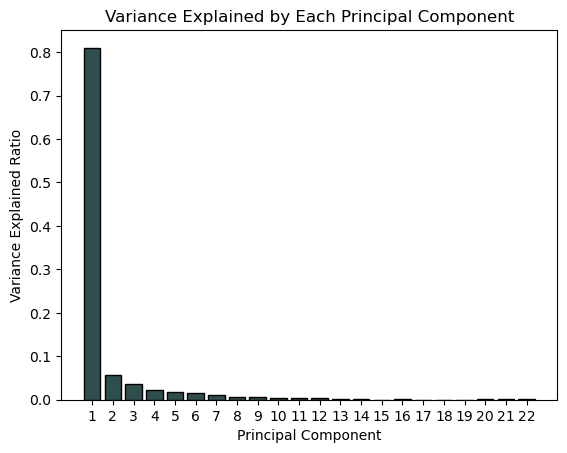

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(1,len(perc_eigen)+1), perc_eigen, color='darkslategray', edgecolor='black')
plt.xticks(range(1, len(perc_eigen)+1))
plt.title("Variance Explained by Each Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained Ratio")
plt.show()

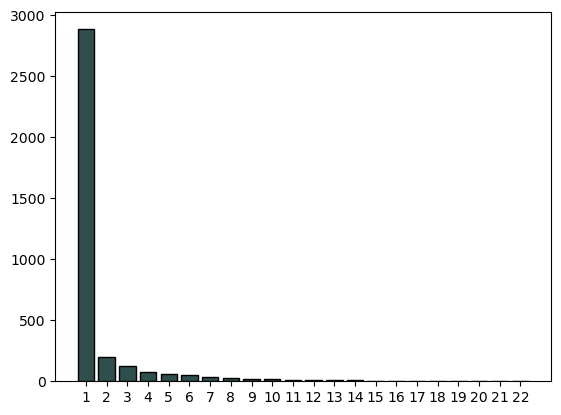

In [110]:
import matplotlib.pyplot as plt

plt.bar(range(1,len(vals)+1), vals, color='darkslategray', edgecolor='black')
plt.xticks(range(1, len(vals)+1))
plt.show()

In [111]:
vecs[:2].round(2)

array([[-0.16, -0.44,  0.19, -0.03,  0.57,  0.35,  0.34, -0.02,  0.13,
        -0.31,  0.11,  0.06,  0.1 , -0.12,  0.02,  0.01,  0.08,  0.06,
        -0.04, -0.08, -0.01, -0.  ],
       [-0.22, -0.03,  0.23,  0.14, -0.14, -0.04, -0.12, -0.02, -0.19,
        -0.17,  0.35, -0.14,  0.15,  0.14, -0.07,  0.19, -0.06,  0.35,
        -0.19,  0.34,  0.41,  0.33]])

In [115]:
pd.DataFrame(vecs[:2].round(2))

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.16,-0.44,0.19,-0.03,0.57,0.35,0.34,-0.02,0.13,-0.31,...,0.10,-0.12,0.02,0.01,0.08,0.06,-0.04,-0.08,-0.01,-0.00
1,-0.22,-0.03,0.23,0.14,-0.14,-0.04,-0.12,-0.02,-0.19,-0.17,...,0.15,0.14,-0.07,0.19,-0.06,0.35,-0.19,0.34,0.41,0.33


In [116]:
# step 4, sort the eigenvectors by the eigenvalues

idxs = pd.Series(vals).argsort()
idxs

0     14
1     16
2     17
3     18
4     19
5     20
6     21
7     15
8     13
9     12
10    11
11    10
12     9
13     8
14     7
15     6
16     5
17     4
18     3
19     2
20     1
21     0
dtype: int64

In [117]:
def set_columns(df_):
    df_.columns = [f'PC{i+1}' for i in range(len(df_.columns))]
    return df_

In [118]:
comps = (pd.DataFrame(vecs, index=nums.columns)
         .iloc[:, idxs[::-1]]
         .pipe(set_columns)
         )

In [119]:
comps

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
Background,-0.163793,-0.438263,0.185140,-0.029498,0.574862,0.353691,0.340477,-0.020726,0.132323,-0.309479,...,0.103288,-0.122220,0.010114,-0.003342,-0.008518,-0.077504,-0.044865,0.061550,0.084777,0.017618
Imagination,-0.221305,-0.033741,0.233670,0.139844,-0.142825,-0.044391,-0.120262,-0.017242,-0.192804,-0.166525,...,0.145997,0.141999,0.191044,0.325120,0.410130,0.339750,-0.187267,0.347679,-0.060294,-0.065134
Integrity,-0.163592,-0.462030,-0.492682,0.087658,0.180732,-0.309459,-0.333331,-0.204760,-0.053825,0.149144,...,0.337371,-0.071876,-0.186124,0.022184,-0.033956,0.037922,-0.106134,0.123903,-0.022157,-0.012286
Intelligence,-0.197460,-0.417192,0.193787,0.155311,-0.206196,0.181656,-0.070460,0.247766,-0.215684,0.221463,...,0.054186,0.351674,0.056570,0.075356,-0.107287,0.062553,0.372864,-0.175805,-0.074996,0.005522
Luck,-0.164359,0.454729,-0.328724,0.318733,0.256324,0.555753,-0.244122,0.113893,-0.195876,-0.053078,...,0.024590,0.024688,-0.142052,0.016526,0.000189,0.063148,-0.045104,0.083363,-0.067409,-0.014529
Willing_to_take_risks,-0.189281,0.179606,0.302450,0.330336,0.094575,-0.128084,-0.008553,-0.579590,-0.191722,-0.071227,...,0.123459,0.254593,-0.011479,-0.297997,-0.290929,-0.055163,0.123062,-0.101888,0.112415,0.060436
Ability_to_compromise,-0.189751,0.062476,-0.161713,-0.669338,-0.169005,0.133793,0.238294,-0.178101,-0.501139,-0.124837,...,0.148000,0.126998,-0.052108,-0.066803,-0.047905,0.029427,-0.092550,0.067472,0.036926,0.009390
Executive_ability,-0.225749,0.104435,0.043649,0.015120,-0.000063,-0.173287,0.057712,-0.032850,0.142261,0.088581,...,-0.117914,-0.214158,0.016502,-0.108075,-0.092441,0.525693,-0.197779,-0.018620,0.470855,0.035541
Leadership_ability,-0.228070,0.135522,0.077745,0.026018,0.029433,-0.265123,0.079115,-0.094222,0.059313,-0.365031,...,-0.048830,-0.280194,-0.053447,0.043778,0.186809,0.098644,0.452270,0.124941,-0.386578,-0.032029
Communication_ability,-0.224135,-0.062321,0.205468,0.122303,-0.210612,-0.067227,-0.103262,0.409168,-0.130153,-0.326035,...,0.002136,-0.186671,-0.169302,0.102953,-0.436502,-0.070234,-0.284278,-0.006474,0.140273,-0.001625


In [122]:
# step 5, take the dot product of the centered data and the eigenvectors to get the principal components
centered.dot(comps)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
1,87.474845,0.343354,15.13609,0.319261,-1.370759,-5.640118,-0.584691,10.918323,-4.273028,1.814237,...,3.699082,-1.132851,1.862105,-1.472647,1.021361,-2.823856,-0.078493,-0.957798,2.29834,0.08404
2,36.726875,28.341533,-0.141936,-12.799483,-1.393458,-5.864385,5.484258,2.771515,-9.492632,-0.807844,...,4.416453,-4.295668,-2.57738,2.619615,-0.032178,2.496395,-0.419608,-0.562758,-0.283342,0.23437
3,74.211148,4.599394,-8.008068,-6.239459,-9.52727,-0.721009,2.021527,-4.056598,7.277679,2.615218,...,7.046873,-1.190451,-2.32823,-2.514392,1.314546,1.139393,-1.218807,0.833371,0.835738,0.097331
4,59.347214,14.357032,-1.319422,7.813056,-4.101478,-4.314507,6.658086,-2.736742,4.777991,0.816661,...,-1.322846,-4.263364,-0.654347,0.642871,-1.50144,1.693013,2.848588,1.967425,0.336845,-0.069161
5,55.382885,-3.715517,13.071949,2.821242,-6.374843,-5.045385,-6.465173,0.146274,-0.412017,-0.456407,...,-1.088657,1.882862,1.889486,-3.056828,-0.652758,-1.131632,-0.940061,1.693808,-2.49279,0.19123
6,23.346035,31.381836,-0.233826,-10.528938,2.834607,-4.132504,-2.63108,-0.45473,-0.019505,6.423498,...,-4.906616,-0.182061,-2.613741,0.011882,0.335008,-0.897474,1.814325,-1.532502,-0.155704,-0.251396
7,13.801013,-31.457747,-8.201122,-20.718215,-6.995829,13.280043,10.376084,-2.305912,0.470769,-0.122862,...,0.235282,0.297712,-0.590423,0.384971,-1.221381,-0.766053,-1.268421,0.612393,0.393442,0.23577
8,-15.417633,3.030631,-4.954373,9.305965,-2.908657,6.584603,-2.44357,-6.468134,5.054438,-0.794447,...,-0.566037,-0.894457,-2.920225,0.512882,-2.45971,-0.389012,0.108649,1.534858,1.220492,0.078202
9,-68.835359,10.874894,-7.646848,-1.49,-7.7976,10.143779,0.197861,-0.066157,-4.27066,11.388613,...,-1.907028,3.423078,2.576855,1.088632,1.574097,2.02016,-0.369201,0.522054,1.531844,0.554887
10,-57.188001,-5.706992,3.728721,-14.256407,4.145336,-5.910248,-3.986758,2.476642,2.687298,1.040249,...,1.42801,-1.189057,1.0429,0.895152,1.900436,-0.018364,0.576269,-1.520552,-0.150566,-0.120081


In [125]:
# 1. Center the data (subtract the mean from each column)
# 2. Calculate the covariance matrix
# 3. Calculate the eigenvectors and eigenvalues of the covariance matrix
# 4. Sort the eigenvectors by the eigenvalues
# 5. Multiply the centered data by the eigenvectors

import numpy as np
centered = nums - nums.mean() # 1
vals, vecs = np.linalg.eig(centered.cov()) # 2 & 3
idxs = pd.Series(vals).argsort() # 4

explained_variance = pd.Series(sorted(vals, reverse=True),
                               index=[f'PC{i+1}' for i in range(len(nums.columns))])

def set_columns(df_):
    df_.columns = [f'PC{i+1}' for i in range(len(nums.columns))]
    return df_

comps = (pd.DataFrame(vecs, index=nums.columns)
         .iloc[:, idxs[::-1]]
         .pipe(set_columns)
         )

pcas = (centered.dot(comps)) # 5
pcas


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
1,87.474845,0.343354,15.13609,0.319261,-1.370759,-5.640118,-0.584691,10.918323,-4.273028,1.814237,...,3.699082,-1.132851,1.862105,-1.472647,1.021361,-2.823856,-0.078493,-0.957798,2.29834,0.08404
2,36.726875,28.341533,-0.141936,-12.799483,-1.393458,-5.864385,5.484258,2.771515,-9.492632,-0.807844,...,4.416453,-4.295668,-2.57738,2.619615,-0.032178,2.496395,-0.419608,-0.562758,-0.283342,0.23437
3,74.211148,4.599394,-8.008068,-6.239459,-9.52727,-0.721009,2.021527,-4.056598,7.277679,2.615218,...,7.046873,-1.190451,-2.32823,-2.514392,1.314546,1.139393,-1.218807,0.833371,0.835738,0.097331
4,59.347214,14.357032,-1.319422,7.813056,-4.101478,-4.314507,6.658086,-2.736742,4.777991,0.816661,...,-1.322846,-4.263364,-0.654347,0.642871,-1.50144,1.693013,2.848588,1.967425,0.336845,-0.069161
5,55.382885,-3.715517,13.071949,2.821242,-6.374843,-5.045385,-6.465173,0.146274,-0.412017,-0.456407,...,-1.088657,1.882862,1.889486,-3.056828,-0.652758,-1.131632,-0.940061,1.693808,-2.49279,0.19123
6,23.346035,31.381836,-0.233826,-10.528938,2.834607,-4.132504,-2.63108,-0.45473,-0.019505,6.423498,...,-4.906616,-0.182061,-2.613741,0.011882,0.335008,-0.897474,1.814325,-1.532502,-0.155704,-0.251396
7,13.801013,-31.457747,-8.201122,-20.718215,-6.995829,13.280043,10.376084,-2.305912,0.470769,-0.122862,...,0.235282,0.297712,-0.590423,0.384971,-1.221381,-0.766053,-1.268421,0.612393,0.393442,0.23577
8,-15.417633,3.030631,-4.954373,9.305965,-2.908657,6.584603,-2.44357,-6.468134,5.054438,-0.794447,...,-0.566037,-0.894457,-2.920225,0.512882,-2.45971,-0.389012,0.108649,1.534858,1.220492,0.078202
9,-68.835359,10.874894,-7.646848,-1.49,-7.7976,10.143779,0.197861,-0.066157,-4.27066,11.388613,...,-1.907028,3.423078,2.576855,1.088632,1.574097,2.02016,-0.369201,0.522054,1.531844,0.554887
10,-57.188001,-5.706992,3.728721,-14.256407,4.145336,-5.910248,-3.986758,2.476642,2.687298,1.040249,...,1.42801,-1.189057,1.0429,0.895152,1.900436,-0.018364,0.576269,-1.520552,-0.150566,-0.120081


In [126]:
from sklearn.decomposition import PCA
from sklearn import set_config

In [127]:
set_config(transform_output='pandas')
pca = PCA()
pca.fit_transform(nums).round(2)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21
1,-87.47,-0.34,-15.14,-0.32,-1.37,-5.64,-0.58,-10.92,-4.27,1.81,...,3.70,-1.13,-1.86,-1.47,-1.02,-2.82,-0.08,0.96,2.30,-0.08
2,-36.73,-28.34,0.14,12.80,-1.39,-5.86,5.48,-2.77,-9.49,-0.81,...,4.42,-4.30,2.58,2.62,0.03,2.50,-0.42,0.56,-0.28,-0.23
3,-74.21,-4.60,8.01,6.24,-9.53,-0.72,2.02,4.06,7.28,2.62,...,7.05,-1.19,2.33,-2.51,-1.31,1.14,-1.22,-0.83,0.84,-0.10
4,-59.35,-14.36,1.32,-7.81,-4.10,-4.31,6.66,2.74,4.78,0.82,...,-1.32,-4.26,0.65,0.64,1.50,1.69,2.85,-1.97,0.34,0.07
5,-55.38,3.72,-13.07,-2.82,-6.37,-5.05,-6.47,-0.15,-0.41,-0.46,...,-1.09,1.88,-1.89,-3.06,0.65,-1.13,-0.94,-1.69,-2.49,-0.19
6,-23.35,-31.38,0.23,10.53,2.83,-4.13,-2.63,0.45,-0.02,6.42,...,-4.91,-0.18,2.61,0.01,-0.34,-0.90,1.81,1.53,-0.16,0.25
7,-13.80,31.46,8.20,20.72,-7.00,13.28,10.38,2.31,0.47,-0.12,...,0.24,0.30,0.59,0.38,1.22,-0.77,-1.27,-0.61,0.39,-0.24
8,15.42,-3.03,4.95,-9.31,-2.91,6.58,-2.44,6.47,5.05,-0.79,...,-0.57,-0.89,2.92,0.51,2.46,-0.39,0.11,-1.53,1.22,-0.08
9,68.84,-10.87,7.65,1.49,-7.80,10.14,0.20,0.07,-4.27,11.39,...,-1.91,3.42,-2.58,1.09,-1.57,2.02,-0.37,-0.52,1.53,-0.55
10,57.19,5.71,-3.73,14.26,4.15,-5.91,-3.99,-2.48,2.69,1.04,...,1.43,-1.19,-1.04,0.90,-1.90,-0.02,0.58,1.52,-0.15,0.12


In [128]:
pca.components_[:2].round(3)

array([[ 0.164,  0.221,  0.164,  0.197,  0.164,  0.189,  0.19 ,  0.226,
         0.228,  0.224,  0.235,  0.208,  0.213,  0.223,  0.221,  0.231,
         0.231,  0.212,  0.208,  0.235,  0.238,  0.238],
       [ 0.438,  0.034,  0.462,  0.417, -0.455, -0.18 , -0.062, -0.104,
        -0.136,  0.062,  0.068, -0.245, -0.155,  0.153, -0.107,  0.051,
        -0.123,  0.011, -0.036,  0.014, -0.003,  0.002]])

In [130]:
(pd.DataFrame(pca.components_, index=[f'pca{i}' for i in range(nums.shape[1])],
              columns=nums.columns))

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise,Executive_ability,Leadership_ability,Communication_ability,...,Relations_with_Congress,Court_appointments,Handling_of_economy,Executive_appointments,Domestic_accomplishments,Foreign_policy_accomplishments,Avoid_crucial_mistakes,Experts'_view,Overall,Average_rank
pca0,0.163793,0.221305,0.163592,0.197460,0.164359,0.189281,0.189751,0.225749,0.228070,0.224135,...,0.212750,0.223400,0.220965,0.231492,0.230920,0.212334,0.208037,0.235395,0.238318,0.238427
pca1,0.438263,0.033741,0.462030,0.417192,-0.454729,-0.179606,-0.062476,-0.104435,-0.135522,0.062321,...,-0.155270,0.152966,-0.107449,0.051246,-0.123209,0.010516,-0.035619,0.014226,-0.003287,0.002321
pca2,-0.185140,-0.233670,0.492682,-0.193787,0.328724,-0.302450,0.161713,-0.043649,-0.077745,-0.205468,...,-0.033467,-0.001356,0.019424,-0.030222,-0.061097,0.194671,0.486695,0.110834,0.023624,0.019445
pca3,0.029498,-0.139844,-0.087658,-0.155311,-0.318733,-0.330336,0.669338,-0.015120,-0.026018,-0.122303,...,0.279040,0.178563,0.060180,0.133021,0.035962,-0.331434,-0.057668,-0.006368,-0.008083,-0.008353
pca4,0.574862,-0.142825,0.180732,-0.206196,0.256324,0.094575,-0.169005,-0.000063,0.029433,-0.210612,...,0.375240,-0.016428,-0.346421,-0.110029,-0.114734,-0.078094,-0.042191,-0.091762,0.011390,0.022508
pca5,0.353691,-0.044391,-0.309459,0.181656,0.555753,-0.128084,0.133793,-0.173287,-0.265123,-0.067227,...,-0.138767,0.299647,0.243792,0.047551,0.084118,-0.011579,-0.207780,-0.043008,-0.029634,-0.021436
pca6,0.340477,-0.120262,-0.333331,-0.070460,-0.244122,-0.008553,0.238294,0.057712,0.079115,-0.103262,...,-0.057811,-0.314372,0.088526,-0.075432,-0.067891,0.670571,0.138550,-0.137742,0.015913,0.033794
pca7,0.020726,0.017242,0.204760,-0.247766,-0.113893,0.579590,0.178101,0.032850,0.094222,-0.409168,...,-0.023564,0.080550,0.001584,0.032409,0.253656,-0.030586,-0.239609,-0.002306,0.030740,0.052146
pca8,0.132323,-0.192804,-0.053825,-0.215684,-0.195876,-0.191722,-0.501139,0.142261,0.059313,-0.130153,...,0.266184,0.033612,0.617150,0.001010,0.047630,-0.127561,0.064084,0.039289,0.017252,0.026522
pca9,-0.309479,-0.166525,0.149144,0.221463,-0.053078,-0.071227,-0.124837,0.088581,-0.365031,-0.326035,...,0.159745,0.161408,0.025695,0.096383,0.208363,0.425664,-0.349695,-0.139259,-0.014581,-0.013918


In [132]:
pd.Series(pca.explained_variance_ratio_,
          index=[f'pca{i+1}' for i in range(nums.shape[1])])

pca1     0.810091
pca2     0.056344
pca3     0.035071
pca4     0.021705
pca5     0.017334
pca6     0.014948
pca7     0.010267
pca8     0.006628
pca9     0.005668
pca10    0.005016
pca11    0.003726
pca12    0.003585
pca13    0.002480
pca14    0.001878
pca15    0.001456
pca16    0.001123
pca17    0.000905
pca18    0.000582
pca19    0.000500
pca20    0.000414
pca21    0.000258
pca22    0.000022
dtype: float64

In [133]:
# Exercises

In [197]:
# Create a dataframe from the data and add it to itself.

part1 = (nums
 .iloc[:3, :7])

part1 + part1

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise
1,14,14,2,20,2,12,4
2,6,26,8,8,48,28,62
3,4,4,28,2,16,10,28


In [198]:
# Create a dataframe from the data and multiply it by two
result = part1 * 2
result

,Background,Imagination,Integrity,Intelligence,Luck,Willing_to_take_risks,Ability_to_compromise
1,14,14,2,20,2,12,4
2,6,26,8,8,48,28,62
3,4,4,28,2,16,10,28


In [199]:
# Are the results from the previous exercises equivalent?

# Yes they are